In [ ]:
!pip install pandas_path
!pip install fasttext
!pip install pytorch_lightning
!pip install transformers
!pip install sentencepiece

In [ ]:
%matplotlib inline

import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_path  # Path style access for pandas
from tqdm import tqdm

In [ ]:
import torch                    
import torchvision
import fasttext

torch.cuda.empty_cache()

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp /content/gdrive/MyDrive/hateful_memes.zip /content/

In [ ]:
!unzip hateful_memes.zip

In [ ]:
data_dir = "hateful_memes"

img_tar_path = data_dir + "/img.tar.gz"
train_path = data_dir + "/train.jsonl"
dev_path = data_dir + "/dev_unseen.jsonl"
test_path = data_dir + "/test_unseen.jsonl"

In [ ]:
data_dir, img_tar_path, test_path

('hateful_memes',
 'hateful_memes/img.tar.gz',
 'hateful_memes/test_unseen.jsonl')

In [ ]:
train_samples_frame = pd.read_json(train_path, lines=True)
train_samples_frame.head()

id            img  label  \
0  42953  img/42953.png      0   
1  23058  img/23058.png      0   
2  13894  img/13894.png      0   
3  37408  img/37408.png      0   
4  82403  img/82403.png      0   

                                                text  
0   its their character not their color that matters  
1  don't be afraid to love again everyone is not ...  
2                           putting bows on your pet  
3  i love everything and everybody! except for sq...  
4  everybody loves chocolate chip cookies, even h...

In [ ]:
train_samples_frame.label.value_counts()


0    5481
1    3019
Name: label, dtype: int64

In [ ]:
train_samples_frame.text.map(
    lambda text: len(text.split(" "))
).describe()

count    8500.000000
mean       11.748706
std         6.877880
min         1.000000
25%         7.000000
50%        10.000000
75%        15.000000
max        70.000000
Name: text, dtype: float64

In [ ]:
from PIL import Image


images = [
    Image.open(
        data_dir + "/" + train_samples_frame.loc[i, "img"]
    ).convert("RGB")
    for i in range(5)
]

for image in images:
    print(image.size)

(265, 400)
(800, 533)
(558, 800)
(693, 800)
(550, 416)


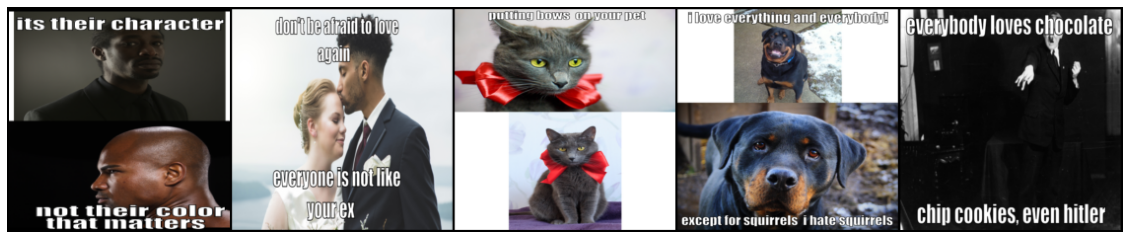

In [ ]:
# define a callable image_transform with Compose
image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor()
    ]
)

# convert the images and prepare for visualization.
tensor_img = torch.stack(
    [image_transform(image) for image in images]
)
grid = torchvision.utils.make_grid(tensor_img)

# plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

In [ ]:
class HatefulMemesDataset(torch.utils.data.Dataset):
    """Uses jsonl data to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(
        self,
        data_path,
        img_dir,
        image_transform,
        text_transform,
        hyperparam,
        balance=False,
        dev_limit=None,
        random_state=0,
    ):
        
        self.samples_frame = pd.read_json(
            data_path, lines=True
        )
        self.dev_limit = dev_limit
        if balance:
            neg = self.samples_frame[
                self.samples_frame.label.eq(0)
            ]
            pos = self.samples_frame[
                self.samples_frame.label.eq(1)
            ]
            self.samples_frame = pd.concat(
                [
                    neg.sample(
                        pos.shape[0], 
                        random_state=random_state
                    ), 
                    pos
                ]
            )
        if self.dev_limit:
            if self.samples_frame.shape[0] > self.dev_limit:
                self.samples_frame = self.samples_frame.sample(
                    dev_limit, random_state=random_state
                )
        self.samples_frame = self.samples_frame.reset_index(
            drop=True
        )
        self.samples_frame.img = self.samples_frame.apply(
            lambda row: (img_dir + "/" + row.img), axis=1
        )

        self.bert_model = hyperparam.get('bert_model', None)
        self.padding = hyperparam.get('padding', 'max_length')
        self.max_length = hyperparam.get('max_length', 512)
        self.truncation = hyperparam.get('truncation', True)
        self.return_tensors = hyperparam.get('return_tensors', 'pt')
        if self.bert_model is not None:
          self.tokenizer = tf.AutoTokenizer.from_pretrained(self.bert_model)
        else:
          self.tokenizer = None

        # https://github.com/drivendataorg/pandas-path
        # if not self.samples_frame.img.path.exists().all():
        #     raise FileNotFoundError
        # if not self.samples_frame.img.path.is_file().all():
        #     raise TypeError
            
        self.image_transform = image_transform
        self.text_transform = text_transform

    def __len__(self):
        """This method is called when you do len(instance) 
        for an instance of this class.
        """
        return len(self.samples_frame)

    def __getitem__(self, idx):
        """This method is called when you do instance[key] 
        for an instance of this class.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.samples_frame.loc[idx, "id"]

        image = Image.open(
            self.samples_frame.loc[idx, "img"]
        ).convert("RGB")
        image = self.image_transform(image)

        if self.tokenizer is None:
          text = torch.Tensor(
              self.text_transform.get_sentence_vector(
                  self.samples_frame.loc[idx, "text"]
              )
          ).squeeze()
        else:
          text = self.tokenizer(self.samples_frame.loc[idx, "text"],
                                padding=self.padding, max_length=self.max_length,
                                truncation=self.truncation, 
                                return_tensors=self.return_tensors)

        if "label" in self.samples_frame.columns:
            label = torch.Tensor(
                [self.samples_frame.loc[idx, "label"]]
            ).long().squeeze()
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text, 
                "label": label
            }
        else:
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text
            }

        return sample

In [ ]:
from torch.nn.modules import dropout
from torch import nn
import transformers as tf

class BertClassifier(nn.Module):

    def __init__(self, loss_fn, hyperparam):

        super(BertClassifier, self).__init__()

        # dropout_p = hyperparam.get('dropout_p', 0.5)
        bert_model = hyperparam.get('bert_model', 'bert-base-cased')
        freeze_bert = hyperparam.get('freeze_bert', False)
        # linear_input_dim = hyperparam.get('linear_input_dim', 769)

        print(bert_model)
        self.bert = tf.AutoModel.from_pretrained(bert_model)

        if freeze_bert:
          for p in self.bert.parameters():
                p.requires_grad = False

        # self.dropout = nn.Dropout(dropout_p)
        # self.linear = nn.Linear(linear_input_dim, 2)
        self.loss_fn = loss_fn


    def forward(self, text, image, labels=None):
        
        mask = text['attention_mask'].squeeze()
        input_id = text['input_ids'].squeeze()
        type_ids = text.get('token_type_ids', None)
      
        if type_ids is not None:
          token_type_ids = type_ids.squeeze()
          _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask,
                                       token_type_ids=token_type_ids, return_dict=False)
        else:
          _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)

        # dropout_output = self.dropout(pooled_output)
        # preds = self.linear(dropout_output)
        
        # loss = (self.loss_fn(preds, labels) if labels is not None else labels)
        # return (preds, loss)
        return pooled_output

In [ ]:
class LanguageAndVisionConcat(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        loss_fn,
        language_module,
        vision_module,
        language_feature_dim,
        vision_feature_dim,
        fusion_output_size,
        dropout_p,
        
    ):
        super(LanguageAndVisionConcat, self).__init__()
        self.language_module = language_module
        self.vision_module = vision_module
        self.fusion = torch.nn.Linear(
            in_features=(language_feature_dim + vision_feature_dim), 
            out_features=fusion_output_size
        )
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )
        self.loss_fn = loss_fn
        self.dropout = torch.nn.Dropout(dropout_p)
        
    def forward(self, text, image, label=None):
        text_features = torch.nn.functional.relu(
            self.language_module(text, image)
        )
        image_features = torch.nn.functional.relu(
            self.vision_module(image)
        )
        combined = torch.cat(
            [text_features, image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            )
        )
        logits = self.fc(fused)
        pred = torch.nn.functional.softmax(logits)
        loss = (
            self.loss_fn(pred, label) 
            if label is not None else label
        )
        return (pred, loss)

In [ ]:
from torch.optim import optimizer
from torchmetrics.functional import accuracy
import pytorch_lightning as pl


# for the purposes of this post, we'll filter
# much of the lovely logging info from our LightningModule
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.WARNING)


class HatefulMemesModel(pl.LightningModule):
    def __init__(self, hparams):
        for data_key in ["train_path", "dev_path", "img_dir",]:
            # ok, there's one for-loop but it doesn't count
            if data_key not in hparams.keys():
                raise KeyError(
                    f"{data_key} is a required hparam in this model"
                )
        
        super(HatefulMemesModel, self).__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()
        
        # assign some hparams that get used in multiple places
        self.embedding_dim = self.hparams.get("embedding_dim", 300)
        self.language_feature_dim = self.hparams.get(
            "language_feature_dim", 300
        )
        self.vision_feature_dim = self.hparams.get(
            # balance language and vision features by default
            "vision_feature_dim", self.language_feature_dim
        )

        self.output_path = Path(
            self.hparams.get("output_path", "model-outputs")
        )
        self.output_path.mkdir(exist_ok=True)
        # instantiate transforms, datasets
        self.text_transform = self._build_text_transform()
        self.image_transform = self._build_image_transform()
        self.train_dataset = self._build_dataset("train_path")
        self.dev_dataset = self._build_dataset("dev_path")
        self.test_dataset = self._build_dataset("test_path")
        
        # set up model and training
        self.model = self._build_model()
        self.trainer_params, self.callback_list = self._get_trainer_params()
    
    ## Required LightningModule Methods (when validating) ##
    
    def forward(self, text, image, label=None):
        return self.model(text, image, label)

    def training_step(self, batch, batch_nb):
        preds, loss = self.forward(
            text=batch["text"], 
            image=batch["image"], 
            label=batch["label"]
        )
        
        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        preds, loss = self.eval().forward(
            text=batch["text"], 
            image=batch["image"], 
            label=batch["label"]
        )
        
        acc = accuracy(preds, batch["label"])
        return {"batch_val_loss": loss, "batch_val_acc": acc}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack(
            tuple(
                output["batch_val_loss"] 
                for output in outputs
            )
        ).mean()

        avg_acc = torch.stack(
            tuple(
                output["batch_val_acc"]
                for output in outputs
            )
        ).mean()

        print(f"    Epoch {self.current_epoch}  acc: {avg_acc}  loss: {avg_loss}")
        
        self.log("val_loss", avg_loss)
        return {
            "val_loss": avg_loss,
            "val_acc": avg_acc,
            "progress_bar":{"val_loss": avg_loss, "val_acc": avg_acc}
        }
    
    def test_step(self, batch, batch_nb):
        preds, loss = self.eval().forward(
            text=batch["text"], 
            image=batch["image"], 
            label=batch["label"]
        )
        
        acc = accuracy(preds, batch["label"])
        return {"batch_test_loss": loss, "batch_test_acc": acc}
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack(
            tuple(
                output["batch_test_loss"] 
                for output in outputs
            )
        ).mean()

        avg_acc = torch.stack(
            tuple(
                output["batch_test_acc"]
                for output in outputs
            )
        ).mean()

        print(f"    final test acc: {avg_acc}  test loss: {avg_loss}")
      
        # self.log("val_loss", avg_loss)
        # return {
        #     "val_loss": avg_loss,
        #     "val_acc": avg_acc,
        #     "progress_bar":{"val_loss": avg_loss, "val_acc": avg_acc}
        # }

    def configure_optimizers(self):
        optimizers = [
            torch.optim.AdamW(
                self.model.parameters(), 
                lr=self.hparams.get("lr", 0.001)
            )
        ]
        schedulers = [
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizers[0]
            )
        ]
        # return optimizers, schedulers, ['avg_val_loss']
        return {
            'optimizer': optimizers[0], 
            'lr_scheduler': schedulers[0],
            'monitor': 'val_loss'
        }
    
    # @pl.data_loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, 
            shuffle=True, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16)
        )

    # @pl.data_loader
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.dev_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16)
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset, 
            shuffle=False,
            batch_size=self.hparams.get("batch_size", 4),
            num_workers=self.hparams.get("num_workers", 16)
        )
    
    ## Convenience Methods ##
    
    def fit(self):
        self._set_seed(self.hparams.get("random_state", 42))
        self.trainer = pl.Trainer(**self.trainer_params)
        # self.trainer = pl.Trainer.from_argparse_args(dict(**self.trainer_params))

        self.trainer.fit(self)
      
    def test(self):
        self._set_seed(self.hparams.get("random_state", 42))
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.test(self)

        
    def _set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    def _build_text_transform(self):
        with tempfile.NamedTemporaryFile() as ft_training_data:
            ft_path = Path(ft_training_data.name)
            with ft_path.open("w") as ft:
                training_data = [
                    json.loads(line)["text"] + "/n" 
                    for line in open(
                        self.hparams.get("train_path")
                    ).read().splitlines()
                ]
                for line in training_data:
                    ft.write(line + "\n")
                language_transform = fasttext.train_unsupervised(
                    str(ft_path),
                    model=self.hparams.get("fasttext_model", "cbow"),
                    dim=self.embedding_dim
                )
        return language_transform
    
    def _build_image_transform(self):
        image_dim = self.hparams.get("image_dim", 224)
        image_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(
                    size=(image_dim, image_dim)
                ),        
                torchvision.transforms.ToTensor(),
                # all torchvision models expect the same
                # normalization mean and std
                # https://pytorch.org/docs/stable/torchvision/models.html
                torchvision.transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)
                ),
            ]
        )
        return image_transform

    def _build_dataset(self, dataset_key):
        return HatefulMemesDataset(
            data_path=self.hparams.get(dataset_key, dataset_key),
            img_dir=self.hparams.get("img_dir"),
            image_transform=self.image_transform,
            text_transform=self.text_transform,
            hyperparam=self.hparams,
            # limit training samples only
            dev_limit=(
                self.hparams.get("dev_limit", None) 
                if "train" in str(dataset_key) else None
            ),
            balance=True if "train" in str(dataset_key) else False,
        )
    
    def _build_model(self):
        # we're going to pass the outputs of our text
        # transform through an additional trainable layer
        # rather than fine-tuning the transform
        # language_module = torch.nn.Linear(
        #         in_features=self.embedding_dim,
        #         out_features=self.language_feature_dim
        # )
        language_module = BertClassifier(torch.nn.CrossEntropyLoss(), self.hparams)
        # easiest way to get features rather than
        # classification is to overwrite last layer
        # with an identity transformation, we'll reduce
        # dimension using a Linear layer, resnet is 2048 out
        vision_module = torchvision.models.wide_resnet50_2(
            pretrained=True
        )
        vision_module.fc = torch.nn.Linear(
                in_features=2048,
                out_features=self.vision_feature_dim
        )

        return LanguageAndVisionConcat(
            num_classes=self.hparams.get("num_classes", 2),
            loss_fn=torch.nn.CrossEntropyLoss(),
            language_module=language_module,
            vision_module=vision_module,
            language_feature_dim=self.language_feature_dim,
            vision_feature_dim=self.vision_feature_dim,
            fusion_output_size=self.hparams.get(
                "fusion_output_size", 512
            ),
            dropout_p=self.hparams.get("dropout_p", 0.1),
        )
    
    def _get_trainer_params(self):
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            # dirpath=self.dir_path,
            # filename=self.output_path,
            # filepath=self.output_path,
            monitor=self.hparams.get(
                "checkpoint_monitor", "val_loss"
            ),
            mode=self.hparams.get(
                "checkpoint_monitor_mode", "min"
            ),
            verbose=self.hparams.get("verbose", True)
        )

        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=self.hparams.get(
                "early_stop_monitor", "val_loss"
            ),
            mode=self.hparams.get(
                "early_stop_mode", "min"
            ),
            min_delta=self.hparams.get(
                "early_stop_min_delta", 0.001
            ),
            patience=self.hparams.get(
                "early_stop_patience", 3
            ),
            verbose=self.hparams.get("verbose", True),
        )

        callback_list = [checkpoint_callback, early_stop_callback]

        trainer_params = {
            # "checkpoint_callback": checkpoint_callback,
            # "early_stop_callback": early_stop_callback,
            # "default_save_path": self.output_path,
            "enable_checkpointing": True,
            "accumulate_grad_batches": self.hparams.get(
                "accumulate_grad_batches", 1
            ),
            "gpus": self.hparams.get("n_gpu", 1),
            "max_epochs": self.hparams.get("max_epochs", 100),
            "gradient_clip_val": self.hparams.get(
                "gradient_clip_value", 1
            ),
            "callbacks": callback_list,
        }

        return trainer_params, callback_list
            
    @torch.no_grad()
    def make_submission_frame(self, test_path):
        test_dataset = self._build_dataset(test_path)
        submission_frame = pd.DataFrame(
            index=test_dataset.samples_frame.id,
            columns=["proba", "label"]
        )
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16))
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            preds, _ = self.model.eval().to("cpu")(
                batch["text"], batch["image"]
            )
            submission_frame.loc[batch["id"], "proba"] = preds[:, 1]
            submission_frame.loc[batch["id"], "label"] = preds.argmax(dim=1)
        submission_frame.proba = submission_frame.proba.astype(float)
        submission_frame.label = submission_frame.label.astype(int)
        return submission_frame

In [ ]:
hparams = {
    
    # Required hparams
    "train_path": train_path,
    "dev_path": dev_path,
    "test_path": test_path,
    "img_dir": data_dir,
    
    # Optional hparams
    "embedding_dim": 100,
    "language_feature_dim": 1024,
    "vision_feature_dim": 1024,
    "fusion_output_size": 1024,
    "output_path": "model-outputs",
    "dev_limit": None,
    "lr": 1e-6,
    "max_epochs": 30,
    "n_gpu": 1,
    "batch_size": 16,
    # allows us to "simulate" having larger batches 
    "accumulate_grad_batches": 16,
    "early_stop_patience": 10,

    # params for bert if use bert
    "dropout_p": 0.5,
    "bert_model": "roberta-large", # # roberta-large #albert-base-v2 #roberta-base # GroNLP/hateBERT #cardiffnlp/twitter-roberta-base-hate
    "padding": "max_length",
    "max_length": 128,
    "truncation": True,
    "return_tensors": "pt",
    "freeze_bert": False,
    # 'linear_input_dim': 1024
}

# GroNLP/hateBERT val acc 0.6060049533843994 test acc 0.6175000071525574 lr 0.001


hateful_memes_model = HatefulMemesModel(hparams=hparams)

roberta-large


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
hateful_memes_model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | LanguageAndVisionConcat | 426 M 
--------------------------------------------------
426 M     Trainable params
0         Non-trainable params
426 M     Total params
1,705.570 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

    Epoch 0  acc: 0.40625  loss: 0.6968601942062378


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.693
Epoch 0, global step 24: 'val_loss' reached 0.69324 (best 0.69324), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=0-step=24.ckpt' as top 1


    Epoch 0  acc: 0.500612735748291  loss: 0.6932418346405029


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 48: 'val_loss' reached 0.69295 (best 0.69295), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=1-step=48.ckpt' as top 1


    Epoch 1  acc: 0.5281862616539001  loss: 0.6929484009742737


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 72: 'val_loss' reached 0.69251 (best 0.69251), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=2-step=72.ckpt' as top 1


    Epoch 2  acc: 0.5416666865348816  loss: 0.6925138831138611


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 96: 'val_loss' was not in top 1


    Epoch 3  acc: 0.5361520051956177  loss: 0.6928994655609131


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 120: 'val_loss' reached 0.69240 (best 0.69240), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=4-step=120.ckpt' as top 1


    Epoch 4  acc: 0.5520833134651184  loss: 0.6923983097076416


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 144: 'val_loss' was not in top 1


    Epoch 5  acc: 0.5281862616539001  loss: 0.692899227142334


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 168: 'val_loss' was not in top 1


    Epoch 6  acc: 0.5465685725212097  loss: 0.692416787147522


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.692
Epoch 7, global step 192: 'val_loss' reached 0.69183 (best 0.69183), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=7-step=192.ckpt' as top 1


    Epoch 7  acc: 0.5373774170875549  loss: 0.6918346285820007


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.689
Epoch 8, global step 216: 'val_loss' reached 0.68925 (best 0.68925), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=8-step=216.ckpt' as top 1


    Epoch 8  acc: 0.5925244688987732  loss: 0.6892539858818054


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.686
Epoch 9, global step 240: 'val_loss' reached 0.68597 (best 0.68597), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=9-step=240.ckpt' as top 1


    Epoch 9  acc: 0.6219362616539001  loss: 0.6859703063964844


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.683
Epoch 10, global step 264: 'val_loss' reached 0.68336 (best 0.68336), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=10-step=264.ckpt' as top 1


    Epoch 10  acc: 0.625612735748291  loss: 0.6833631992340088


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.681
Epoch 11, global step 288: 'val_loss' reached 0.68096 (best 0.68096), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=11-step=288.ckpt' as top 1


    Epoch 11  acc: 0.6219362616539001  loss: 0.6809601783752441


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 312: 'val_loss' reached 0.68058 (best 0.68058), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=12-step=312.ckpt' as top 1


    Epoch 12  acc: 0.6145833134651184  loss: 0.6805771589279175


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.677
Epoch 13, global step 336: 'val_loss' reached 0.67719 (best 0.67719), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=13-step=336.ckpt' as top 1


    Epoch 13  acc: 0.625612735748291  loss: 0.6771858930587769


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.674
Epoch 14, global step 360: 'val_loss' reached 0.67350 (best 0.67350), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=14-step=360.ckpt' as top 1


    Epoch 14  acc: 0.6164215207099915  loss: 0.6735014319419861


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 384: 'val_loss' reached 0.67291 (best 0.67291), saving model to '/content/lightning_logs/version_13/checkpoints/epoch=15-step=384.ckpt' as top 1


    Epoch 15  acc: 0.6164215207099915  loss: 0.6729143261909485


In [ ]:
print("please change the checkpoint directory based on the latest model")

please change the checkpoint directory based on the latest model


In [ ]:
# we should only have saved the best checkpoint
checkpoints = list(Path("/content/lightning_logs/version_13/checkpoints").glob("*.ckpt"))
# assert len(checkpoints) == 1
checkpoints

[PosixPath('/content/lightning_logs/version_13/checkpoints/epoch=15-step=384.ckpt')]

In [ ]:
hateful_meme_model = HatefulMemesModel.load_from_checkpoint(
    checkpoints[0]
)

roberta-large


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
hateful_meme_model.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

    final test acc: 0.6185000538825989  test loss: 0.6698682904243469


In [ ]:
############## log for Resnet152 + bert-hate

# Metric val_loss improved. New best score: 0.693
# Epoch 0, global step 24: 'val_loss' reached 0.69309 (best 0.69309), saving model to '/content/lightning_logs/version_5/checkpoints/epoch=0-step=24.ckpt' as top 1
#     Epoch 0  acc: 0.506740152835846  loss: 0.6930868625640869
# Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.683
# Epoch 1, global step 48: 'val_loss' reached 0.68311 (best 0.68311), saving model to '/content/lightning_logs/version_5/checkpoints/epoch=1-step=48.ckpt' as top 1
#     Epoch 1  acc: 0.5729166865348816  loss: 0.6831145882606506
# Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.674
# Epoch 2, global step 72: 'val_loss' reached 0.67411 (best 0.67411), saving model to '/content/lightning_logs/version_5/checkpoints/epoch=2-step=72.ckpt' as top 1
#     Epoch 2  acc: 0.59375  loss: 0.6741124391555786
# Epoch 3, global step 96: 'val_loss' was not in top 1
#     Epoch 3  acc: 0.5876225829124451  loss: 0.6760677695274353
# Epoch 4, global step 120: 'val_loss' was not in top 1
#     Epoch 4  acc: 0.6102941036224365  loss: 0.6758342385292053
# Epoch 5, global step 144: 'val_loss' was not in top 1
#     Epoch 5  acc: 0.601715624332428  loss: 0.6783673763275146
# Epoch 6, global step 168: 'val_loss' was not in top 1
#     Epoch 6  acc: 0.5980392098426819  loss: 0.6896845102310181
# Epoch 7, global step 192: 'val_loss' was not in top 1
#     Epoch 7  acc: 0.5808823704719543  loss: 0.6994192004203796
# Epoch 8, global step 216: 'val_loss' was not in top 1
#     Epoch 8  acc: 0.5827205777168274  loss: 0.7011447548866272
# Epoch 9, global step 240: 'val_loss' was not in top 1
#     Epoch 9  acc: 0.5692402124404907  loss: 0.7178584933280945
# Epoch 10, global step 264: 'val_loss' was not in top 1
#     Epoch 10  acc: 0.5716911554336548  loss: 0.7060186862945557
# Epoch 11, global step 288: 'val_loss' was not in top 1
#     Epoch 11  acc: 0.5765931606292725  loss: 0.7167104482650757
# Monitored metric val_loss did not improve in the last 10 records. Best score: 0.674. Signaling Trainer to stop.
# Epoch 12, global step 312: 'val_loss' was not in top 1
#     Epoch 12  acc: 0.6004902124404907  loss: 0.6988473534584045

In [ ]:
# log for wide-resnet + Bert-hate

# Metric val_loss improved. New best score: 0.695
# Epoch 0, global step 24: 'val_loss' reached 0.69545 (best 0.69545), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=0-step=24.ckpt' as top 1
#     Epoch 0  acc: 0.418504923582077  loss: 0.6954457759857178
# Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.691
# Epoch 1, global step 48: 'val_loss' reached 0.69077 (best 0.69077), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=1-step=48.ckpt' as top 1
#     Epoch 1  acc: 0.5557597875595093  loss: 0.6907718777656555
# Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.685
# Epoch 2, global step 72: 'val_loss' reached 0.68497 (best 0.68497), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=2-step=72.ckpt' as top 1
#     Epoch 2  acc: 0.5729166865348816  loss: 0.6849713325500488
# Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.676
# Epoch 3, global step 96: 'val_loss' reached 0.67591 (best 0.67591), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=3-step=96.ckpt' as top 1
#     Epoch 3  acc: 0.5949755311012268  loss: 0.6759073734283447
# Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.671
# Epoch 4, global step 120: 'val_loss' reached 0.67102 (best 0.67102), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=4-step=120.ckpt' as top 1
#     Epoch 4  acc: 0.6066176295280457  loss: 0.6710227727890015
# Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.668
# Epoch 5, global step 144: 'val_loss' reached 0.66793 (best 0.66793), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=5-step=144.ckpt' as top 1
#     Epoch 5  acc: 0.6213235259056091  loss: 0.6679331064224243
# Epoch 6, global step 168: 'val_loss' was not in top 1
#     Epoch 6  acc: 0.6188725829124451  loss: 0.6750087141990662
# Epoch 7, global step 192: 'val_loss' was not in top 1
#     Epoch 7  acc: 0.5980392098426819  loss: 0.6703765988349915
# Epoch 8, global step 216: 'val_loss' was not in top 1
#     Epoch 8  acc: 0.5968137383460999  loss: 0.6786707639694214

In [ ]:
# log for wide_resnet_50_2 + roberta_large

# Epoch 0, global step 24: 'val_loss' reached 0.69625 (best 0.69625), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=0-step=24.ckpt' as top 1
#     Epoch 0  acc: 0.42953428626060486  loss: 0.6962466835975647
# Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.665
# Epoch 1, global step 48: 'val_loss' reached 0.66548 (best 0.66548), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=1-step=48.ckpt' as top 1
#     Epoch 1  acc: 0.6158088445663452  loss: 0.6654825806617737
# Epoch 2, global step 72: 'val_loss' was not in top 1
#     Epoch 2  acc: 0.601715624332428  loss: 0.6786746978759766
# Epoch 3, global step 96: 'val_loss' was not in top 1
#     Epoch 3  acc: 0.6151961088180542  loss: 0.672024667263031
# Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.660
# Epoch 4, global step 120: 'val_loss' reached 0.65979 (best 0.65979), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=4-step=120.ckpt' as top 1
#     Epoch 4  acc: 0.6348038911819458  loss: 0.6597890853881836
# Epoch 5, global step 144: 'val_loss' was not in top 1
#     Epoch 5  acc: 0.6121323704719543  loss: 0.6705300807952881
# Epoch 6, global step 168: 'val_loss' was not in top 1
#     Epoch 6  acc: 0.6072303652763367  loss: 0.6762141585350037
# Epoch 7, global step 192: 'val_loss' was not in top 1
#     Epoch 7  acc: 0.6317402124404907  loss: 0.6633034944534302
# Epoch 8, global step 216: 'val_loss' reached 0.65975 (best 0.65975), saving model to '/content/lightning_logs/version_10/checkpoints/epoch=8-step=216.ckpt' as top 1
#     Epoch 8  acc: 0.6378676295280457  loss: 0.6597460508346558
# Epoch 9, global step 240: 'val_loss' was not in top 1
#     Epoch 9  acc: 0.6341911554336548  loss: 0.6649085879325867